<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/04_Modelos_Supervisados/Regresion/DecisionTree_RandForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árboles de Decisión

Modelo supervisado que divide el espacio de caracteríticas (variables) en regiones homogéneas mediante una estructura jerárquica de decisiones. Se utiliza tanto para clasificación como para regresión.

La idea principal es construir un árbol donde cada nodo es una variable y se divide donde se reduce la varianza (regresión).

Los criterios para realizar la división dependen de las funciones a utilizar. En regresión se utiliza la varianza o la suma de los errores cuadrados.

Entonces, el proceso de construcción del árbol es el siguiente: Se escoje una característica y se calcula la métrica de calidad de todos los posibles split. Se escoje el split que maximice la pureza y se repite este proceso recursivamente. Los criterios de parada pueden ser alcanzar

En regresión, la predicción es el promedio de los valores en la hoja.

Carguemos un dataset para la construcción del modelo.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housesalesprediction


Visualicemos el dataset.

In [ ]:
import pandas as pd

df = pd.read_csv(path + "/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
from sklearn.compose   import ColumnTransformer
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model  import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import numpy as np

Separemos las variables entre numéricas y categóricas.

In [ ]:
num = ["sqft_living", "bathrooms", "lat", "long", "sqft_lot", "bedrooms", "yr_built"]
cat = ["zipcode", "waterfront", "condition", "grade"]

In [ ]:
X = df[num+cat]
y = df["price"]

Hagamos la división de los datos entre entrenamiento y validación.

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

Realicemos la creación del pipeline del modelo.

Dado como se puede observar en el algoritmo del modelo, no es necesario hacer un StandardScaler y por ahora dado que estamos eligiendo las variables que vamos a utilizar en las numericas podemos no utilizar PCA y ver como se comporta el modelo tal cual.

In [ ]:
pre = ColumnTransformer([
    ("num", "passthrough", num),
    ("cat", OneHotEncoder(drop='first',handle_unknown="ignore"), cat)
])

Notemos lo siguiente:

- passthrough: significa no le hagas nada a las variables.

- handle_unknown: es para evitar errores, en el caso de los arboles de decision, cuando las variables categoricas empiezan a hacer las separaciones, si uno no lo agrega puede generar errores.

Importemos el DecisionTreeRegresor

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Definamos la métrica de evaluación de las predicciones.

In [ ]:
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

Vamos a definir el árbol de decisión.

In [ ]:
tree = Pipeline([
    ("pre", pre),
    ("dtr", DecisionTreeRegressor(
        max_depth=5, # Profundidad max, 3-6 si son pocos datos
        min_samples_leaf=10, # Minimo porcentaje para llegar a la ultima hoja
        min_samples_split=2, # Minimo porcentaje para hacer la separacion
        random_state=42 # Semilla
    ))
])

Entrenamiento.

In [ ]:
tree.fit(X_tr, y_tr)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['sqft_living', 'bathrooms',
                                                   'lat', 'long', 'sqft_lot',
                                                   'bedrooms', 'yr_built']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['zipcode', 'waterfront',
                                                   'condition', 'grade'])])),
                ('dtr',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=10,
                                       min_samples_split=10,
                                       random_state=42))])

Procedamos a hacer el grafico de la figura del árbol.

Vamos a mostrar solo hasta la profundidad 2 para efectos de visualizacion, pero el árbol tiene mas profundidad.

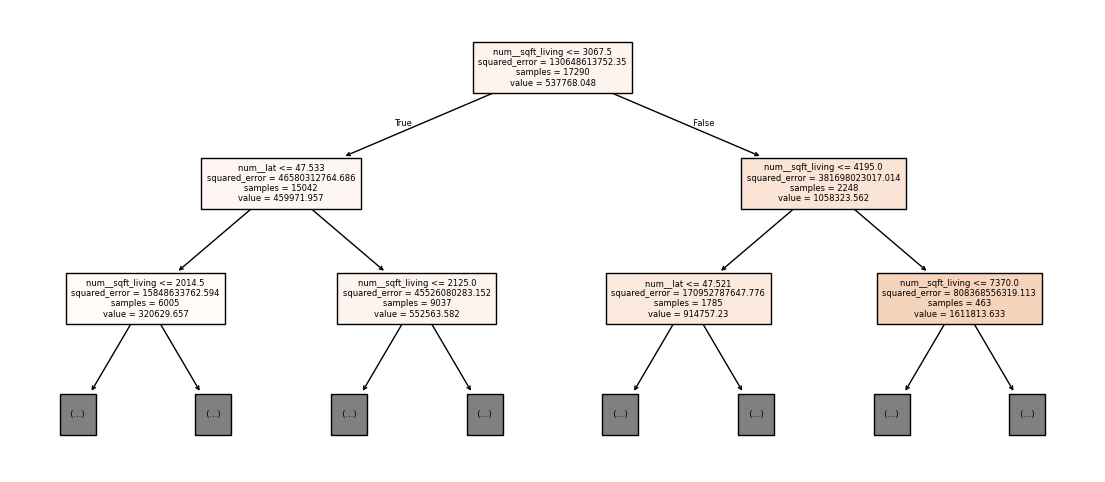

RMSE : 192389.82788927027
R²   : 0.7551617221812926


In [ ]:
plt.figure(figsize=(14,6))
plot_tree(tree.named_steps["dtr"], # Nombre de los pasos del dtr
          feature_names=pre.get_feature_names_out(), # Nombre de las variables
          filled=True,
          fontsize=6,
          max_depth=2)
plt.show()

# Prediccion

y_pred = tree.predict(X_te)
print("RMSE :", rmse(y_te,y_pred))
print("R²   :", r2_score(y_te,y_pred))

Notemos que el error y el R^2 son peores que los entregados con la regresion lineal, (ver notebook de regresión lineal) por lo que procederemos a variar los parametros del árbol para poder obtener una mejor predicción.


In [ ]:
tree = Pipeline([
    ("pre", pre),
    ("dtr", DecisionTreeRegressor(
        max_depth=9,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ))
])

Entrenamiento del modelo.

In [ ]:
tree.fit(X_tr, y_tr)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['sqft_living', 'bathrooms',
                                                   'lat', 'long', 'sqft_lot',
                                                   'bedrooms', 'yr_built']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['zipcode', 'waterfront',
                                                   'condition', 'grade'])])),
                ('dtr',
                 DecisionTreeRegressor(max_depth=9, min_samples_leaf=10,
                                       random_state=42))])

Procedamos a hacer el grafico de la figura del árbol.

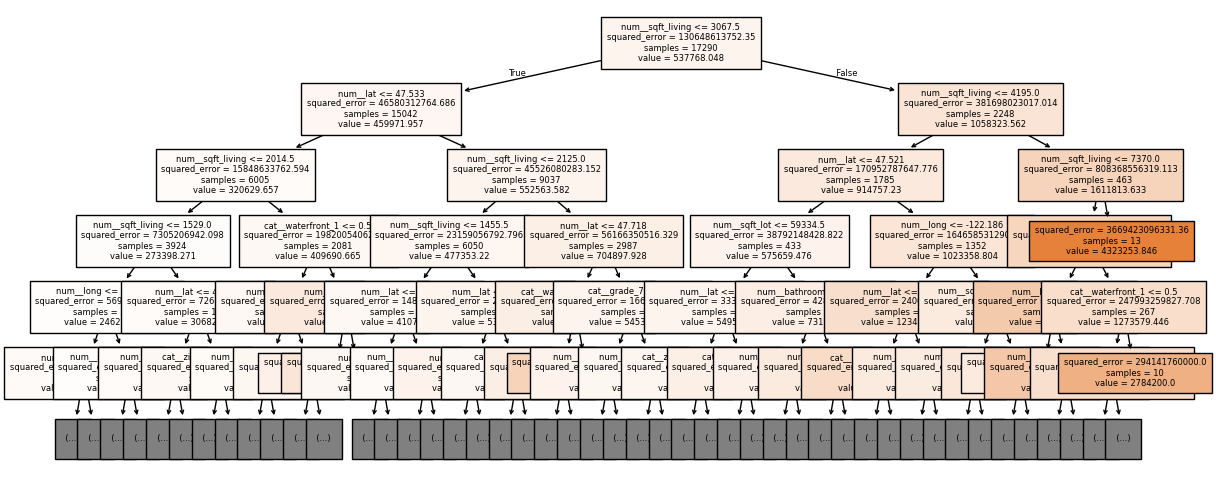

RMSE : 192389.82788927027
R²   : 0.7551617221812926


In [ ]:
plt.figure(figsize=(14,6))
plot_tree(tree.named_steps["dtr"], # Nombre de los pasos del dtr
          feature_names=pre.get_feature_names_out(), # Nombre de las variables
          filled=True,
          fontsize=6,
          max_depth=5)
plt.show()

# Predicción

y_pred = tree.predict(X_te)
print("RMSE :", rmse(y_te,y_pred))
print("R²   :", r2_score(y_te,y_pred))

Existe una forma de ajustar los hiperparámetros del arbol de manera automatica a través del método Grid Search (hay un notebook que es específico de esto).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
pre = ColumnTransformer([
    ("num", "passthrough", num)
])

Notemos que para el pipeline solo le damos la semilla debido a que los otros hiperparámetros se los pasaremos con el Grid Search.

In [ ]:
pipe = Pipeline([
    ("pre", pre),
    ("dtr", DecisionTreeRegressor(random_state=42))
])

Definamos la rejilla de parámetros a evaluar.

In [ ]:
param_grid = {
    "dtr__max_depth": list(range(2,11))
}

Métrica.

In [ ]:
rmse_scorer = make_scorer(
        mean_squared_error, greater_is_better=False)

Definamos el modelo de busqueda en rejilla.

In [ ]:
grid = GridSearchCV(pipe,
                    param_grid, # Rejilla
                    cv=5,
                    scoring=rmse_scorer,
                    return_train_score=True, # Nos entregue el resultado
                    error_score="raise") # Aviso de error

Ahora lo que haremos es entrenar sobre grid. Lo que hará es probar los distintos casos entrenados por los distintos parámetros a evaluar.

In [ ]:
grid.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['sqft_living',
                                                                          'bathrooms',
                                                                          'lat',
                                                                          'long',
                                                                          'sqft_lot',
                                                                          'bedrooms',
                                                                          'yr_built'])])),
                                       ('dtr',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'dtr__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

Ahora procedamos a extraer los resultados

In [ ]:
depths = grid.cv_results_["param_dtr__max_depth"].data
rmse_val = np.sqrt(-grid.cv_results_["mean_test_score"])
rmse_trn = np.sqrt(-grid.cv_results_["mean_train_score"])

Realicemos un gráfico de comparación del error del entrenamiento y de la validación, una vez aumenta la profundidad del árbol.

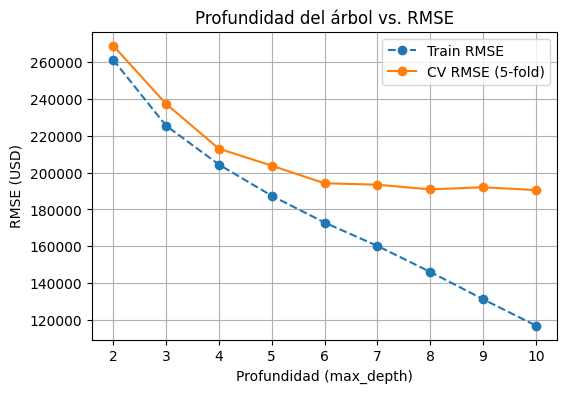

Mejor profundidad: 10
CV-RMSE mínimo  : 190458.79764984729


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(depths, rmse_trn, "o--", label="Train RMSE")
plt.plot(depths, rmse_val, "o-",  label="CV RMSE (5-fold)")
plt.xlabel("Profundidad (max_depth)")
plt.ylabel("RMSE (USD)")
plt.title("Profundidad del árbol vs. RMSE")
plt.legend(); plt.grid(True)
plt.show()

print("Mejor profundidad:", grid.best_params_["dtr__max_depth"])
print("CV-RMSE mínimo  :", rmse_val.min())

Notemos que a mayor profundidad, el entrenamiento se va haciendo mucho mas preciso (va disminuyendo el rmse) pero en el conjunto de validacion el error se mantuvo por lo que el modelo no fue mejorando sino que empezó a realizar un sobreajuste.

Si bien la mejor profundidad es 10 debido al error en la validacion, puede ser que el modelo no sea el adecuado debido a que se está sobreajustando.

# Random Forest

Algoritmo de aprendizaje supervisado basado en árboles de decisión, que utiliza un enfoque de *ensamble* para el mejoramiento de la precisión y la robustez del modelo.

Consiste en construir múltiples árboles de decisión durante el entrenamiento y combinar sus predicciones para tomar una decisión final por promedio de ellas.

Este método reduce significativamente el sobreajuste que puede presentar un solo árbol y mejora la capacidad de generalización.

Carguemos la libreriía RandomForestRegressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Creemos el preprocesamiento de los datos.

In [ ]:
pre = ColumnTransformer([
    ("num", "passthrough", num),
    ("cat", OneHotEncoder(drop='first',handle_unknown="ignore"), cat)
])

Procedamos a construir el pipeline del modelo.

In [ ]:
rf_pipe = Pipeline([
    ("prep", pre),                       # ColumnTransformer
    ("rf",   RandomForestRegressor(
                n_estimators=300,
                max_depth=None,
                random_state=42,
                #n_jobs=-1,
                oob_score=True))
])

Entrenamiento.

In [ ]:
rf_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['sqft_living', 'bathrooms',
                                                   'lat', 'long', 'sqft_lot',
                                                   'bedrooms', 'yr_built']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['zipcode', 'waterfront',
                                                   'condition', 'grade'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       oob_score=True, random_state=42))])

Predicción del modelo con sus métricas respectivas y el top 10 de variables más importantes a la hora de predecir.

In [ ]:
y_pred = rf_pipe.predict(X_te)
print("MAE :", f"{mean_absolute_error(y_te,y_pred):,.0f} USD")
print("RMSE:", f"{rmse(y_te,y_pred):,.0f} USD")
print("R²  :", f"{r2_score(y_te,y_pred):.3f}")
print("OOB R² :", rf_pipe.named_steps["rf"].oob_score_) # Conjunto no testeado

# Top-10 variables mas importantes para la prediccion
imp = rf_pipe.named_steps["rf"].feature_importances_
feat = rf_pipe.named_steps["prep"].get_feature_names_out()
top10 = (pd.Series(imp, index=feat)
           .sort_values(ascending=False)
           .head(10))
display(top10.to_frame("Importance"))

MAE : 72,614 USD
RMSE: 146,063 USD
R²  : 0.859
OOB R² : 0.8738498799635748


,Importance
num__sqft_living,0.547172
num__lat,0.196607
num__long,0.079838
cat__waterfront_1,0.034640
num__sqft_lot,0.031707
num__yr_built,0.020393
num__bathrooms,0.014944
cat__grade_7,0.008910
cat__grade_8,0.006779
cat__grade_12,0.006174


Notemos que los resultados son significativamente mejores en comparación a la predicción con un solo árbol.